In [26]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
sys.path.append('../')

from ase.db import connect
import pyro
from src.models.bnn import BNN, NN
from src.models.nets.network import NetAtom
import torch
import pytorch_lightning as L
import torch.utils.data as data
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from optuna import Study
import optuna
from optuna.trial import Trial

from src.datamodule.aenet_datamodule import AenetDataModule

In [28]:
datamodele = AenetDataModule(
    data_dir='../data/PdO/train.in',
    batch_size=200,
    test_split=0.1,
    valid_split=0.1
    )

In [29]:
net = NetAtom(
    datamodele.input_size, 
    datamodele.hidden_size, 
    datamodele.species, 
    datamodele.active_names, 
    datamodele.alpha,
    'cpu'
)

In [30]:
from torch.optim import Adam

model = NN(net, Adam)
trainer = L.Trainer(max_epochs = 500)
trainer.fit(model=model, datamodule=datamodele)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type    | Params
---------------------------------
0 | net  | NetAtom | 1.9 K 
---------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 8:  82%|████████▏ | 50/61 [00:00<00:00, 140.33it/s, v_num=43]         

In [24]:
trainer.callback_metrics

{'mse/val': tensor(4.2884)}

In [41]:
model_kwargs = {'net': net,
        'lr': 0.00025616626859234823,
        'pretrain_epochs': 5,
        'mc_samples_train': 1,
        'mc_samples_eval': 20, 
        'dataset_size': datamodele.train_size, 
        'fit_context': 'lrt', 
        'prior_loc': 0, 
        'prior_scale': 0.3726682199695302, 
        'guide': 'normal', 
        'q_scale': 0.00127000766093029489207278289472795143,
        'obs_scale' :  0.8115512648735741}

In [42]:
Params = {'lr': 0.0009726653777506587, 
          'mc_samples_train': 1, 
          'obs_scale': 0.23252058562889985, 
          'pretrain_epochs': 0, 
          'prior_scale': 0.010367521982966135, 
          'q_scale': 0.0008246637061794308}
model_kwargs.update(Params)

In [43]:
Params = {'lr': 0.0009752776394469695, 
'mc_samples_train': 1, 
'obs_scale': 0.38446371462009965, 
'pretrain_epochs': 0, 
'guide': 'radial', 
'prior_scale': 0.024533762127898734, 
'q_scale': 0.00019591530194613456}
model_kwargs.update(Params)

In [44]:
early_stopping = EarlyStopping(monitor='elbo/val', min_delta = 0., # minimum change in the monitored quantity to qualify as an improvement
  patience= 3, # number of checks with no improvement after which training will be stopped
  verbose= False, # verbosity mode
  mode= "min", # "max" means higher metric value is better, can be also "min"
  strict= True, # whether to crash the training if monitor is not found in the validation metrics
  check_finite= True,) # when set True, stops training when the monitor becomes NaN or infinite
#   'stopping_threshold'= null, # stop training immediately once the monitored quantity reaches this threshold
#   'divergence_threshold'= null, # stop training as soon as the monitored quantity becomes worse than this threshold
#   'check_on_train_epoch_end'= null,)

early_stopping = EarlyStopping(
    monitor='elbo/val',
    patience=100,
    mode='min' )

In [45]:
model = BNN(**model_kwargs)
trainer = L.Trainer(max_epochs = 500)
trainer.fit(model=model, datamodule=datamodele)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[0.8, 0.1, 0.1]
[0.8, 0.1, 0.1]
[0.8, 0.1, 0.1]



  | Name | Type    | Params
---------------------------------
0 | net  | NetAtom | 1.9 K 
---------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 18:   5%|▍         | 3/61 [00:00<00:01, 33.58it/s, v_num=29]         

In [46]:
trainer.callback_metrics

{'elbo/val': tensor(84.6314),
 'mse/val': tensor(0.1233, dtype=torch.float64),
 'kl/val': tensor(10389.8936),
 'likelihood/val': tensor(-10305.2617),
 'mse/train': tensor(0.3420),
 'elbo/train': tensor(259.5953),
 'kl/train': tensor(10446.0244),
 'likelihood/train': tensor(-10186.4268)}

In [47]:
ckpt_path = trainer.checkpoint_callback.best_model_path

trainer.test(model=model, datamodule=datamodele, ckpt_path=ckpt_path)

[0.8, 0.1, 0.1]
[0.8, 0.1, 0.1]
[0.8, 0.1, 0.1]


Restoring states from the checkpoint path at /home/riccardo/bin/repos/aenet-bnn/notebooks/lightning_logs/version_29/checkpoints/epoch=17-step=1098.ckpt
Loaded model weights from the checkpoint at /home/riccardo/bin/repos/aenet-bnn/notebooks/lightning_logs/version_29/checkpoints/epoch=17-step=1098.ckpt


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         mse/test          │    0.11222723358881963    │
│         nll/test          │    -0.5298802668352723    │
└───────────────────────────┴───────────────────────────┘

[{'nll/test': -0.5298802668352723, 'mse/test': 0.11222723358881963}]

In [10]:
valid = datamodele.grouped_test_data
x = valid[0][10], valid[0][12]
y_true = valid[0][11]
y_pred, y_std = model.bnn.predict(x[0], x[1], num_predictions=800)

y_pred = y_pred.numpy()
y_std = y_std.numpy() #- model_kwargs['obs_scale']
y_true = y_true.numpy()

R2 score: 0.076


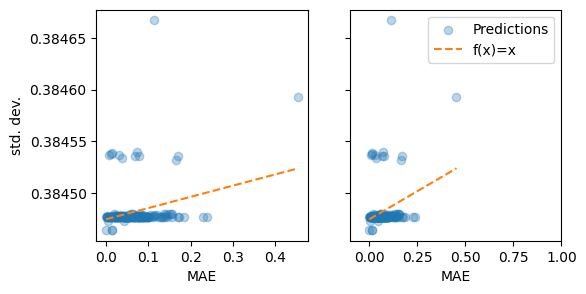

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


regr = LinearRegression()

x_model = abs(y_pred-y_true).reshape(-1,1)
y_model = y_std.reshape(-1,1)

regr.fit(x_model, y_model)
y_model_pred = regr.predict(x_model)
x_modelito = np.linspace(0, max(x_model), 100).reshape(-1,1)


fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)

ax[0].scatter(x_model, y_model, alpha=0.3)
ax[0].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')

#ax[0].text(0.1,0.425, 'R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
print('R2 score: {:.3f}'.format(r2_score(y_model, y_model_pred)))
ax[1].scatter(x_model, y_model, alpha=0.3, label='Predictions')

ax[1].plot(x_modelito, regr.predict(x_modelito), '--', color='tab:orange', label='f(x)=x')

ax[1].set_xlim(-0.1,1)

ax[1].set_xlabel('MAE')
ax[0].set_xlabel('MAE')
ax[0].set_ylabel('std. dev.')
ax[1].legend()
#plt.xlim(0,0.5)

<Axes: title={'center': 'Residuals vs. Predictive Standard Deviations'}, xlabel='Standard Deviations (Scaled)', ylabel='Residuals (Absolute Value)'>

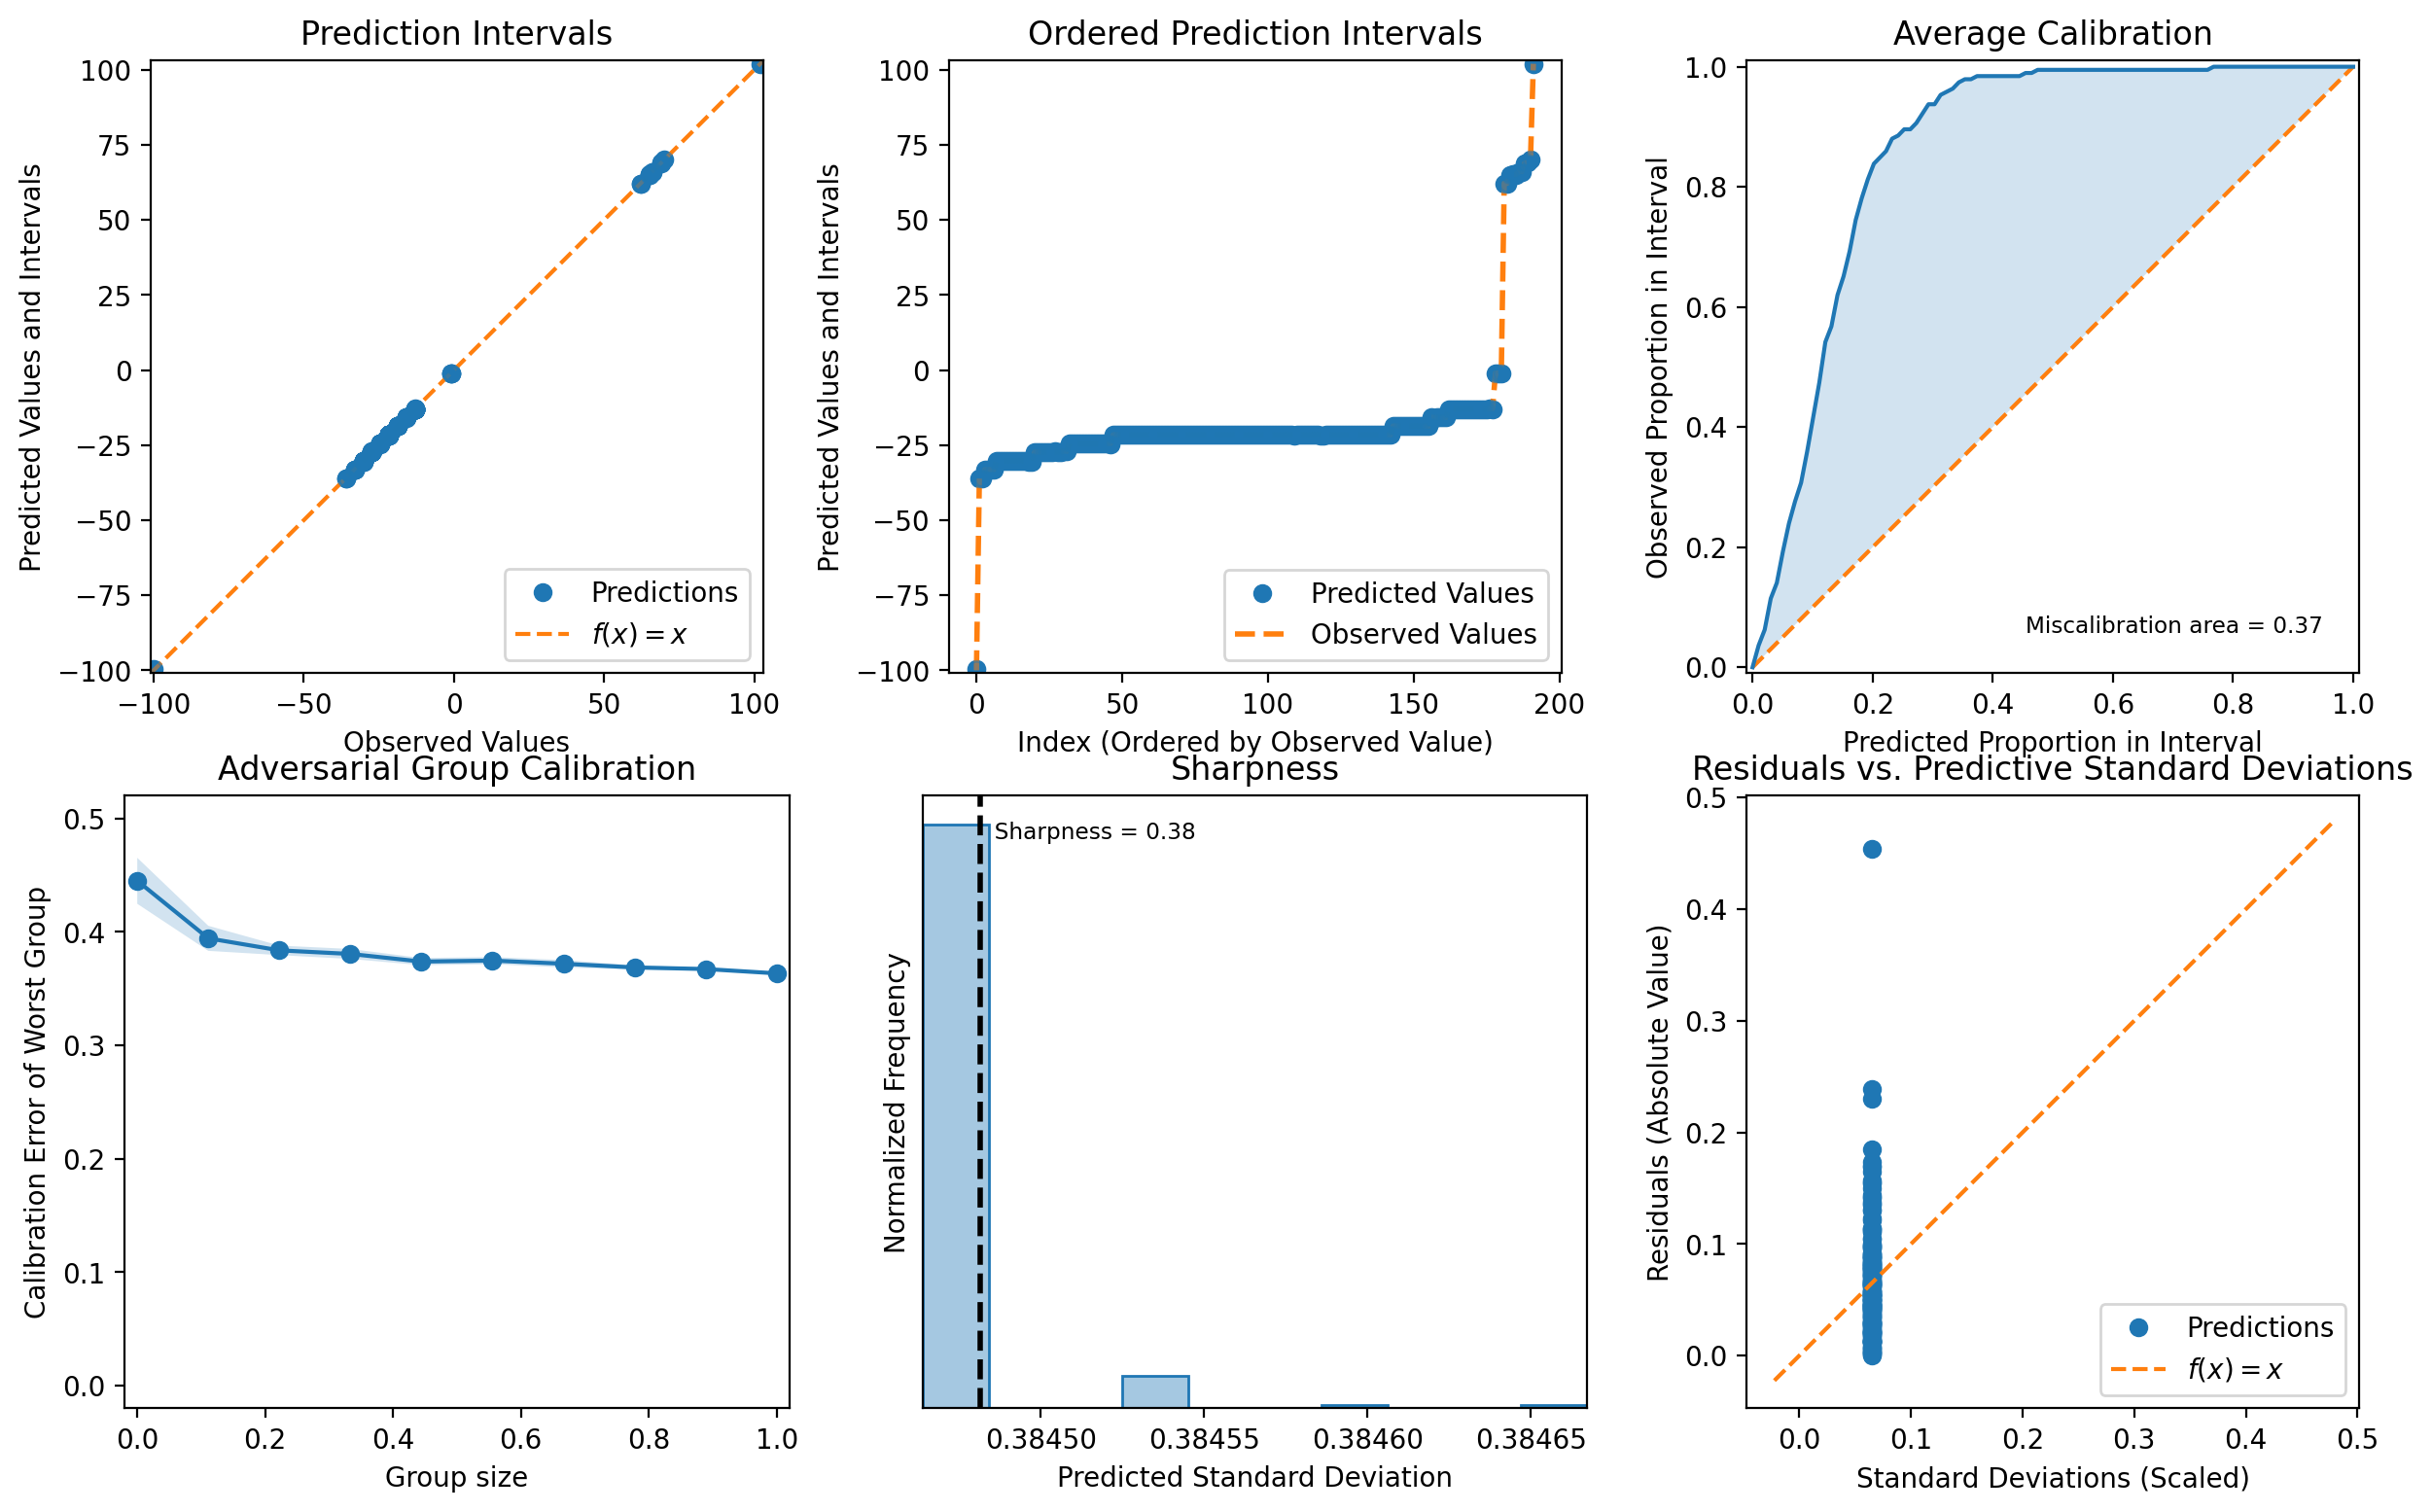

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct

plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(2, 3, figsize=(15, 9))
ax = ax.flat
uct.plot_intervals(y_pred, y_std, y_true, ax=ax[0])
uct.plot_intervals_ordered(y_pred, y_std, y_true, ax=ax[1])
uct.plot_calibration(y_pred, y_std, y_true, ax=ax[2])
uct.plot_adversarial_group_calibration(y_pred, y_std, y_true, ax=ax[3])
uct.plot_sharpness(y_std, ax=ax[4])
uct.plot_residuals_vs_stds(y_pred, y_std, y_true, ax=ax[5])